In [3]:
import os
import rootutils

%load_ext autoreload
%autoreload 2

rootutils.setup_root(os.path.abspath('./'), indicator=".project-root", pythonpath=True, dotenv=True, cwd=True)

WindowsPath('C:/Users/0amir/HopfieldAM')

In [6]:
import shutil
from argparse import Namespace

import jax
import jax.numpy as jnp

import pandas as pd
import matplotlib.pyplot as plt

import jax.numpy as jnp
import jax.random as random
import jax

import equinox as eqx
import optax

import tensorflow_datasets as tfds

from config import CONFIG
from activation_map import ACTIVATION_MAP
from models import get_model
from losses import get_batch_loss
from datasets.dataset_loader import get_dataloader
from datasets.get_dimension import get_dimension
from src.train import train
from src.test import test
from utils.visualization import plot_metrics, plot_energy
from utils.integrate_trajectory import integrate_trajectory, get_energy
from utils.logger import new_run_id, log_experiment, log_summary
from utils.parse_config import parse_config

from tqdm.auto import tqdm
import os
import glob
import re

In [7]:
# os.environ["CUDA_VISIBLE_DEVICES"] = "4"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


In [8]:

def get_best_checkpoint_path(activation, t1, dt, experiments_dir):
    """
    Find the best model checkpoint path given activation, t1, and dt parameters.
    
    Args:
        activation (str): Activation function name (e.g., 'gelu', 'relu', etc.)
        t1 (float): t1 parameter value
        dt (float): dt parameter value
        
    Returns:
        str: Path to the best model checkpoint or None if not found
    """
    # Convert parameters to string format used in directory names
    t1_str = f"t1={t1}"
    dt_str = f"dt={dt}"
    
    # Create pattern to match directory names
    pattern = f"run_*_{activation}_{t1_str}_{dt_str}"
    
    # Search for matching directories
    experiment_dirs = glob.glob(os.path.join(experiments_dir, pattern))
    
    if not experiment_dirs:
        return None
    
    # If multiple directories match, get the most recent one
    # (based on timestamp in directory name)
    if len(experiment_dirs) > 1:
        experiment_dirs.sort(reverse=True)
    
    target_dir = experiment_dirs[0]
    
    # Get the best model file
    best_model_files = glob.glob(os.path.join(target_dir, "best_model*.eqx"))
    
    if not best_model_files:
        return None
    
    return best_model_files[0]

def load_best_model(args: Namespace, experiments_dir):
    ckpt_path = get_best_checkpoint_path(args.activation, args.t1, args.dt, experiments_dir)
    
    N_neurons = get_dimension(args.dataset_name)
    key = random.PRNGKey(19)
    g = ACTIVATION_MAP[args.activation]
    model = get_model(args.model, key=key, N_neurons=N_neurons, g=g)
    model = eqx.tree_deserialise_leaves(ckpt_path, like=model)
    return model



In [ ]:
args = Namespace(
    model="Hopfield",
    loss="loss_last10",
    dataset_name = "mnist",
    epochs=1,
    batch_size=64,
    
    activation = "tanh",
    dt=0.01,
    t1=15.0,
    
    N_classes=10,
)

best_model = load_best_model(args, experiments_dir="experiments_lr_e-4")

In [10]:
# dataset options: mnist fashion_mnist, cifar10, omniglot
train_loader, val_loader, test_loader = get_dataloader(dataset_name=args.dataset_name, batch_size=args.batch_size)

In [13]:
jax.devices()

[CpuDevice(id=0)]

In [11]:
batch_loss = get_batch_loss(args.loss)

test_loss, test_accuracy = test(best_model, test_loader, batch_loss, args.dt, args.t1, args.N_classes)

KeyboardInterrupt: 

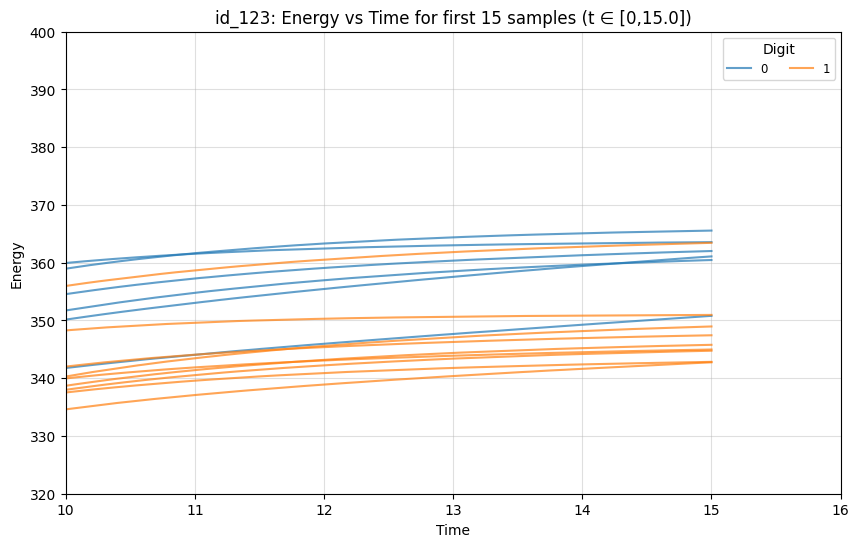

In [20]:
X_batch, y_batch = next(train_loader())
samples = 15

X = []
y = []
for i in range(len(y_batch)):
    if y_batch[i] == 0 or y_batch[i]==1:
        X.append(X_batch[i])
        y.append(y_batch[i])

X = jnp.array(X)
y = jnp.array(y)



plot_energy("id_123", best_model, X, y, args.dt, args.t1, samples, save_plot=False, ylim=(320, 400), xlim=(10, 16))
